In [1]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import bcolz
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from IPython.display import display

import utils
import config

In [2]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [16]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[classes], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [6]:
index = 0
info_string = 'fish'
prefix = os.path.join('cache', info_string + '_' + str(index))

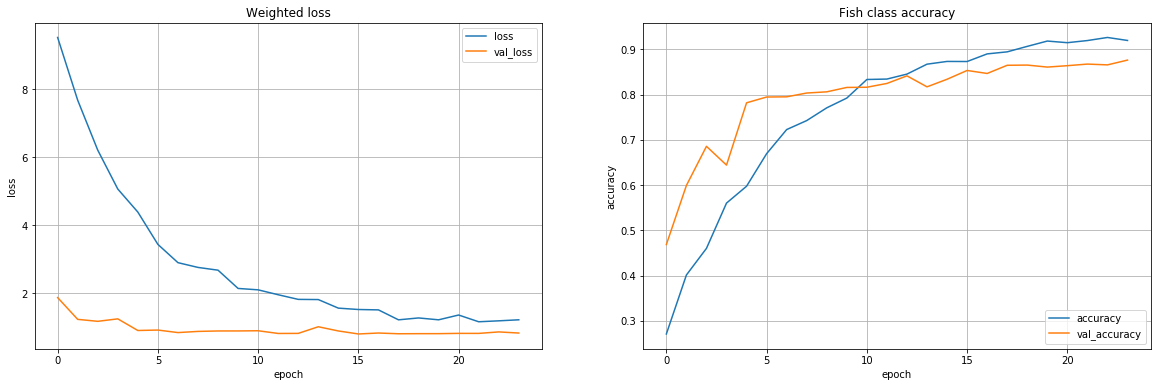

In [7]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [17]:
result = 'cache/fish_0_2017-02-14-14-17.csv'
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array(result)

def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(real, pred))
print('Clipped log loss:', log_loss(real, do_clip(pred, 0.97)))

def clip(x):
    mx = 0.96
    clipped = np.clip(x.values, (1 - mx) / 1, mx)
    clipped /= clipped.sum()
    return clipped

frame = pd.read_csv(result)
frame.ix[:,0:8] = frame.ix[:,0:8].apply(clip, axis=1)
frame.to_csv('cache/clipped_' + os.path.basename(result), index=False)

Diff: 696
Log loss: 3.51729461075
Clipped log loss: 2.02652637215


TypeError: ('unorderable types: str() <= float()', 'occurred at index 0')

In [18]:
frame[cla]

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK
0,img_00005.jpg,0.543076,8.368255e-05,8.711440e-03,1.188112e-04,0.345562,7.213364e-04,2.474838e-05
1,img_00007.jpg,0.004101,7.091102e-03,1.093539e-05,5.000479e-01,0.001978,4.735441e-01,3.747701e-04
2,img_00009.jpg,0.025875,2.220523e-06,1.712598e-06,4.998626e-09,0.971042,1.810586e-03,3.164441e-06
3,img_00018.jpg,0.380611,2.391005e-04,1.733130e-04,6.657420e-06,0.010418,8.102561e-04,1.866563e-03
4,img_00027.jpg,0.500997,1.495571e-07,1.270591e-04,9.168862e-10,0.498380,5.686967e-07,6.377811e-09
5,img_00030.jpg,0.500895,1.011398e-04,2.754679e-05,1.565358e-08,0.000347,8.058313e-05,6.877553e-08
6,img_00040.jpg,0.197822,2.774504e-03,4.588709e-04,1.941424e-02,0.483048,1.810439e-01,1.330554e-02
7,img_00046.jpg,0.981638,1.315684e-02,2.925477e-05,1.510159e-07,0.000372,1.163197e-03,1.700416e-05
8,img_00053.jpg,0.499869,3.188368e-05,1.667542e-08,9.361466e-10,0.000105,6.208134e-06,3.191028e-06
9,img_00071.jpg,0.542920,5.325533e-04,1.916398e-05,4.453573e-06,0.016024,5.483077e-02,8.807136e-02


In [22]:
X_test = utils.load_array('X_test.bcolz')
Id_test = utils.load_array('Id_test.bcolz')
y_test_bb_tl = utils.load_array('y_test_bb_tl.bcolz')
y_test_bb_wh = utils.load_array('y_test_bb_wh.bcolz')

print('X_test:', np.shape(X_test))
print('Id_test:', np.shape(Id_test))
print('y_test_bb_tl:', np.shape(y_test_bb_tl))
print('y_test_bb_wh:', np.shape(y_test_bb_wh))

Id_test_argsort = np.argsort(Id_test)

def show_pred(i, bb=False):
    plt.figure(figsize=(9, 12))
    plot(X_test[Id_test_argsort[i]])
    ax = plt.gca()
    print('Id: ', Id_test[Id_test_argsort[i]])
    p = pred[i]
    print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real:', classes[np.argmax(real[i])])
    if bb:
        box = []
        box.extend(y_test_bb_tl[Id_test_argsort[i]])
        box.extend(y_test_bb_wh[Id_test_argsort[i]])
        print('Box (x,y,w,h): ', box)
        if box[2] > 0 and box[3] > 0:
            ax.add_patch(create_rect_xywh(box, 'yellow'))

X_test: (1000, 448, 448, 3)
Id_test: (1000,)
y_test_bb_tl: (1000, 2)
y_test_bb_wh: (1000, 2)


Id:  img_03261.jpg
Pred: ALB (1.000)
Real: ALB
Box (x,y,w,h):  [180.09094, 228.35617, 82.841141, 86.687691]


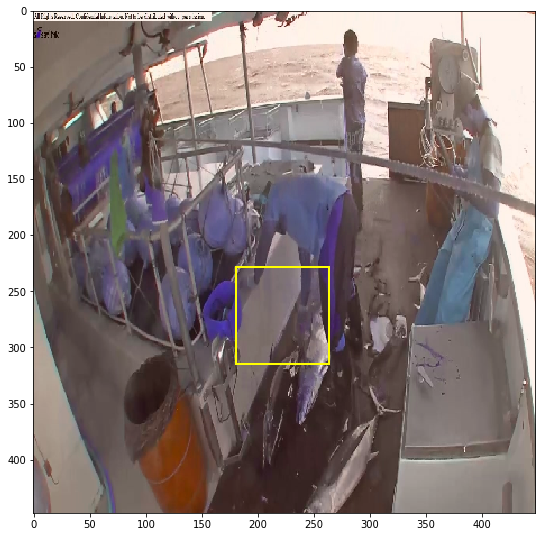

In [28]:
show_pred(400, True)

In [86]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred) * 100.0
    rp = real_p[classes[i]] / len(pred) * 100.0
    print('{}\tpred: {:.2f}%\treal: {:.2f}%\tbias: {:.3f}'.format(classes[i], pp, rp, pp/rp))

ALB	pred: 45.20%	real: 51.50%	bias: 0.878
BET	pred: 7.26%	real: 6.20%	bias: 1.171
DOL	pred: 1.06%	real: 1.60%	bias: 0.662
LAG	pred: 2.33%	real: 3.70%	bias: 0.630
NoF	pred: 13.53%	real: 12.20%	bias: 1.109
OTHER	pred: 6.34%	real: 8.20%	bias: 0.773
SHARK	pred: 1.75%	real: 3.00%	bias: 0.584
YFT	pred: 22.52%	real: 13.60%	bias: 1.656


In [6]:
c_matrix = {}
p_matrix = {
    'TP': {},
    'FP': {},
    'FN': {},
    'TN': {},
    'ACC': {},
    'REC': {},
    'PRE': {},
    'F1': {}
}

for i in range(len(classes)):
    tl = classes[i] + '_T'
    c_matrix[tl] = {}
    for j in range(len(classes)):
        pl = classes[j] + '_P'
        c_matrix[tl][pl] = 0

for i in range(len(classes)):
    cn = classes[i]
    p_matrix['TP'][cn] = 0
    p_matrix['FP'][cn] = 0
    p_matrix['FN'][cn] = 0
    p_matrix['TN'][cn] = 0
    p_matrix['ACC'][cn] = 0
    p_matrix['REC'][cn] = 0
    p_matrix['PRE'][cn] = 0
    p_matrix['F1'][cn] = 0
        
for i in range(len(pred)):
    predicted = classes[np.argmax(pred[i])]
    truelabel = classes[np.argmax(real[i])]
    c_matrix[truelabel + '_T'][predicted + '_P'] += 1
    
    if predicted == truelabel:
        p_matrix['TP'][predicted] += 1
    else:
        p_matrix['FP'][predicted] += 1
        p_matrix['FN'][truelabel] += 1

for i in range(len(classes)):
    cn = classes[i]
    tp = int(p_matrix['TP'][cn])
    fn = int(p_matrix['FN'][cn])
    fp = int(p_matrix['FP'][cn])
    tn = p_matrix['TN'][cn] = len(pred) - (tp + fn + fp)
    p_matrix['ACC'][cn] = (tp + tn) / (tp + tn + fp + fn)
    r = p_matrix['REC'][cn] = tp / (tp + fn)
    p = p_matrix['PRE'][cn] = tp / (tp + fp)
    p_matrix['F1'][cn] = 2 * (p * r) / (p + r)

#pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(c_matrix))
display(pd.DataFrame(p_matrix)[['TP', 'FP', 'TN', 'FN', 'PRE', 'REC', 'F1', 'ACC']])

,ALB_T,BET_T,DOL_T,LAG_T,NoF_T,OTHER_T,SHARK_T,YFT_T
ALB_P,402,33,0,3,8,43,7,24
BET_P,24,9,0,8,2,2,5,5
DOL_P,1,0,5,1,0,0,0,4
LAG_P,3,0,0,23,0,0,0,0
NoF_P,20,1,0,0,107,0,0,0
OTHER_P,12,2,0,0,1,24,1,2
SHARK_P,0,0,0,0,0,0,9,0
YFT_P,53,17,11,2,4,13,8,101


,TP,FP,TN,FN,PRE,REC,F1,ACC
ALB,402,118,367,113,0.773077,0.780583,0.776812,0.769
BET,9,46,892,53,0.163636,0.145161,0.153846,0.901
DOL,5,6,978,11,0.454545,0.312500,0.370370,0.983
LAG,23,3,960,14,0.884615,0.621622,0.730159,0.983
NoF,107,21,857,15,0.835938,0.877049,0.856000,0.964
OTHER,24,18,900,58,0.571429,0.292683,0.387097,0.924
SHARK,9,0,970,21,1.000000,0.300000,0.461538,0.979
YFT,101,108,756,35,0.483254,0.742647,0.585507,0.857
